# A Large-Scale CT and PET/CT Dataset for Lung Cancer Diagnosis (Lung-PET-CT-Dx) https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70224216

# Импорт

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision
from torch.utils.data import random_split
import torch.nn as nn
# import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

In [3]:
!pip install pydicom
from pydicom import dcmread

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 9.9 MB/s 


In [4]:
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 409 kB 6.7 MB/s 


In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Класс Датасета

In [7]:
# class LangerSequence(Dataset):
#     def __init__(self, root, transform=None):
#         self.root = root
#         self.transform = transform
#         self.classes = os.listdir(self.root)
#         self.classes.sort()
#         self.targets = [i for i in range(0, len(self.classes))]

#         self.series_name = []
#         self.classes_lens = []
#         for cls in self.classes:
#           path = os.path.join(self.root, cls)
#           names = os.listdir(path)
#           self.series_name.extend(names)
#           self.classes_lens.append(len(names))

#     def __len__(self):
#         return len(self.series_name)     

#     def __getitem__(self, idx):
#       name = self.series_name[idx]
#       cls = name[0]
#       path = os.path.join(self.root, cls, name)

#       imgs_name = os.listdir(path)
#       imgs_name.sort()
#       images = [] 
#       for name in imgs_name:
#         img_path = os.path.join(path, name)
#         img = dcmread(img_path).pixel_array
#         img = img.astype(np.float32)
#         if transform:
#           img = transform(img)
#         images.append(img)
#       images = torch.stack(images)

#       return images, self.classes.index(cls), len(imgs_name)

In [7]:
class LangerSequence2(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.classes = os.listdir(self.root)
        self.classes.sort()
        self.targets = [i for i in range(0, len(self.classes))]

        self.series_name = []
        self.classes_lens = []
        for cls in self.classes:
          path = os.path.join(self.root, cls)
          names = os.listdir(path)
          self.series_name.extend(names)
          self.classes_lens.append(len(names))
        
        self.series_imgs = []
        self.series_targ = []
        for name in self.series_name:
          cls = name[0]
          path = os.path.join(self.root, cls, name)

          imgs_name = os.listdir(path)
          imgs_name.sort()
          images = [] 
          for name in imgs_name:
            img_path = os.path.join(path, name)
            img = dcmread(img_path).pixel_array
            img = img.astype(np.float32)
            if transform:
              img = transform(img)
            images.append(img)
          images = torch.stack(images)

          self.series_imgs.append(images)
          self.series_targ.append(self.classes.index(cls))

    def __len__(self):
        return len(self.series_name)     

    def __getitem__(self, idx):
      images = self.series_imgs[idx]
      return images, self.series_targ[idx]

In [76]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((256, 256)), 
    #  transforms.Normalize([0.8], [0.129])
    ])

In [9]:
data_dir = '/content/gdrive/My Drive/for cnn rnn'
dataset = LangerSequence2(data_dir, transform=transform)

In [77]:
data_dir_test = '/content/gdrive/My Drive/for cnn rnn test'
ds_test = LangerSequence2(data_dir_test, transform=transform)

In [11]:
print(dataset.classes)
print(dataset.targets)
print(dataset.classes_lens)
print(len(dataset))

['A', 'B', 'E', 'G']
[0, 1, 2, 3]
[28, 15, 4, 8]
55


In [12]:
print(ds_test.classes)
print(ds_test.targets)
print(ds_test.classes_lens)
print(len(ds_test))

['A', 'B', 'E', 'G']
[0, 1, 2, 3]
[4, 3, 2, 2]
11


In [ ]:
dataset[0]

(tensor([[[[-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
           [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
           [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
           ...,
           [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
           [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
           [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.]]],
 
 
         [[[-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
           [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
           [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
           ...,
           [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
           [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
           [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.]]],
 
 
         [[[-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
           [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
           [-2000.

In [ ]:
# [кол-во изображений в серии, кол-во каналов, ширина, высота]
dataset[0][0].shape

torch.Size([36, 1, 256, 256])

In [61]:
def show_img(img, title=''):
  plt.imshow(img)
  plt.title(title)
  plt.axis('off')
  plt.show()

У изображений разная яркость

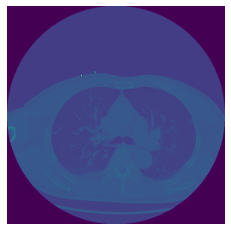

In [ ]:
show_img(dataset[0][0][20][0])

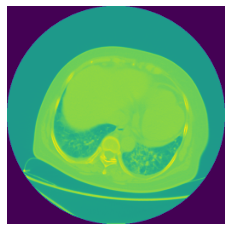

In [72]:
show_img(dataset[14][0][20][0])

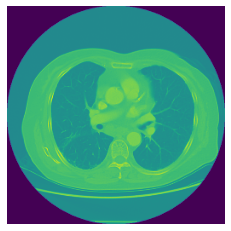

In [62]:
show_img(ds_test[3][0][25][0])

разделить датасет на train и val

In [13]:
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
ds_train, ds_val = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

In [ ]:
# # https://discuss.pytorch.org/t/how-to-create-batches-of-a-list-of-varying-dimension-tensors/50773/14
# def collate_fn(data):
#     """
#        data: is a list of tuples with (example, label, length)
#              where 'example' is a tensor of arbitrary shape
#              and label/length are scalars
#     """
    
#     _, labels, lengths = zip(*data)
#     max_len = max(lengths)
#     n_ftrs = data[0][0].size(1)
#     h, w = data[0][0].size(2), data[0][0].size(3)
#     features = torch.zeros(len(data), max_len, n_ftrs, h, w)
    
#     labels = torch.tensor(labels)
#     lengths = torch.tensor(lengths)
    
#     for i in range(len(data)):
#       j = data[i][0].size(0)  # кол-во изображений в серии
#       features[i] = torch.cat([data[i][0], torch.zeros(max_len - j, n_ftrs, h, w)])

#     return features.float(), labels.long(), lengths.long()

DataLoader

In [78]:
batch_size=1
dl_train = DataLoader(ds_train, batch_size, num_workers=2, shuffle=True, pin_memory=True)
dl_val = DataLoader(ds_val, batch_size, num_workers=2, shuffle=True, pin_memory=True)
dl_test = DataLoader(ds_test, batch_size, num_workers=2, shuffle=True, pin_memory=True)

In [ ]:
# размерность одного из батчей
next(iter(dl_train))[0].shape

torch.Size([1, 56, 1, 256, 256])

In [ ]:
# значения одного батча
next(iter(dl_train))

[tensor([[[[[-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
            [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
            [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
            ...,
            [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
            [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
            [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.]]],
 
 
          [[[-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
            [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
            [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
            ...,
            [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
            [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
            [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.]]],
 
 
          [[[-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
            [-2000., -2000., -2000.,  ..., -2000., -2000., -2000.],
  

# Модель

In [15]:
# https://github.com/PacktPublishing/PyTorch-Computer-Vision-Cookbook/blob/master/Chapter10/Chapter10.ipynb
from torch import nn
class Resnt18Rnn(nn.Module):
    def __init__(self, params_model):
        super(Resnt18Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        
        baseModel = models.resnet18(pretrained=False)
        baseModel.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0
        y = self.baseModel(x[:,ii])
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        for ii in range(1, ts):
            y = self.baseModel((x[:,ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn.to(device), cn.to(device)))
        out = self.dropout(out[:,-1])
        out = self.fc1(out) 
        return out 
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x    

In [79]:
params_model={
        "num_classes": 4,
        "dr_rate": 0.3,
        "rnn_num_layers": 1,
        "rnn_hidden_size": 200,}
model = Resnt18Rnn(params_model).to(device)

In [17]:
# предсказание класса одной серии
ser, lbl = dataset[0]
ser = ser.to(device)
serb = ser.unsqueeze(0)  # батч из 1 изоборажения
preds_prob = model(serb)

_, preds = torch.max(preds_prob, dim=1)
pred = preds[0].item()

print(f"label_orig: {lbl}")
print(f"label_pred_prob: {preds_prob}")
print(f"label_pred: {pred}")

label_orig: 0
label_pred_prob: tensor([[ 0.0152, -0.0945, -0.1327, -0.1910]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
label_pred: 0


In [38]:
serb, lbl = next(iter(dl_train))
serb = serb.to(device)
preds_prob = model(serb)

print(f"label_pred_prob: {preds_prob}")

label_pred_prob: tensor([[-5.9162e-01,  1.3686e-01, -2.4708e-04,  7.0862e-01]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


# Функции обучения

In [18]:
# проверить качество модели на dataLoader (получить среднии loss и метрику по всем батчам)
def evaluate(params):
    model = params["model"]
    dloader = params["dl_val"]
    loss_fn = params["loss_fn"]
    metrics_fn = params["metrics_fn"]

    model.eval()
    with torch.no_grad():
        mean_loss = [] # сюда будем складывать средний лосс по батчам
        accuracy = []
        
        for seq, labels in dloader:
            seq = seq.to(device)
            labels = labels.to(device)
            
            preds = model(seq)
            loss = loss_fn(preds, labels)
            metrics = metrics_fn(preds, labels)

            mean_loss.append(loss.cpu().numpy()) # добавляем в массив
            accuracy.append(metrics.cpu())
        
        return np.mean(mean_loss), np.mean(accuracy)

In [19]:
def fit(params):
    num_epochs =  params["num_epochs"]
    model =      params["model"]
    loss_fn =    params["loss_fn"]
    opt =        params["opt"]
    dl_train =   params["dl_train"]
    dl_val =     params["dl_val"]
    metrics_fn = params["metrics_fn"]

    history = {'acc': [], 'val_acc': [], 'loss': [], 'val_loss': []}
    
    for epoch in range(num_epochs): 
        
        # обучение
        model.train()
        for imgs, labels in dl_train: # train_dl сам перемешается и разделиться при каждой следующей эпохе
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            preds = model(imgs) # предсказываем
            loss = loss_fn(preds, labels) # вычисляем ошибку
            loss.backward() # вычисляем градиент loss_fn по весам и смещениям
            opt.step() # делаем шаг к уменьшению ошибки - обновляем веса и смещения
            opt.zero_grad() # обнуляем градиент, чтобы значения не накапливались
            
            
        # Каждые 1 эпох вывод прогресса и сохранение истории
        if (epoch+1) % 1 == 0:
            acc_train = metrics_fn(preds, labels)
            loss_val, acc_val = evaluate(params)
            
            # вывод статистики
            print('Epoch [{}/{}], loss: {:.4f} - acc: {:.4f}, val_loss: {:.4f} - val_acc: {:.4f}'
                  .format(epoch+1, num_epochs, loss, acc_train, loss_val, acc_val))
            
            # сохранение истории    
            history['acc'].append(acc_train)
            history['val_acc'].append(acc_val)
            history['loss'].append(loss)
            history['val_loss'].append(loss_val)
            
    return history

# Обучение модели

In [80]:
params_train={
        "num_epochs": 20,
        "model": model.to(device),
        "loss_fn": nn.CrossEntropyLoss(), 
        "opt": torch.optim.Adam(model.parameters(), lr=0.0001),
        "dl_train": dl_train,
        "dl_val": dl_val,
        "metrics_fn": torchmetrics.Accuracy(average='macro', num_classes=4).to(device),
        }

In [81]:
# до обучения
loss, acc = evaluate(params_train)
print('loss: {:.4f} - acc: {:.4f}'.format(loss, acc))

loss: 1.4229 - acc: 0.3636


In [82]:
history = fit(params_train)

Epoch [1/20], loss: 0.5722 - acc: 1.0000, val_loss: 1.3747 - val_acc: 0.3636
Epoch [2/20], loss: 0.6717 - acc: 1.0000, val_loss: 1.3998 - val_acc: 0.3636
Epoch [3/20], loss: 1.4940 - acc: 0.0000, val_loss: 1.3518 - val_acc: 0.3636
Epoch [4/20], loss: 0.3819 - acc: 1.0000, val_loss: 1.3358 - val_acc: 0.4545
Epoch [5/20], loss: 1.2481 - acc: 0.0000, val_loss: 1.1009 - val_acc: 0.6364
Epoch [6/20], loss: 0.1066 - acc: 1.0000, val_loss: 1.7033 - val_acc: 0.3636
Epoch [7/20], loss: 0.1849 - acc: 1.0000, val_loss: 1.0000 - val_acc: 0.6364
Epoch [8/20], loss: 0.1077 - acc: 1.0000, val_loss: 0.9015 - val_acc: 0.7273
Epoch [9/20], loss: 0.0494 - acc: 1.0000, val_loss: 1.5195 - val_acc: 0.3636
Epoch [10/20], loss: 0.0243 - acc: 1.0000, val_loss: 1.7149 - val_acc: 0.3636
Epoch [11/20], loss: 0.0358 - acc: 1.0000, val_loss: 0.7305 - val_acc: 0.8182
Epoch [12/20], loss: 0.0089 - acc: 1.0000, val_loss: 1.2877 - val_acc: 0.6364
Epoch [13/20], loss: 0.0156 - acc: 1.0000, val_loss: 1.7558 - val_acc: 0.

In [85]:
# torch.save(model.state_dict(), '/content/gdrive/My Drive/resnet18_rnn_2.pth')

# Тестирование

In [89]:
model = Resnt18Rnn(params_model).to(device)
model.load_state_dict(torch.load('/content/gdrive/My Drive/resnet18_rnn_1.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [90]:
params_test={
        "model": model.to(device),
        "loss_fn": nn.CrossEntropyLoss(), 
        "dl_val": dl_test,
        "metrics_fn": torchmetrics.Accuracy(average='macro', num_classes=4).to(device),
        }
loss, acc = evaluate(params_test)
print('loss: {:.4f} - acc: {:.4f}'.format(loss, acc))

loss: 2.2522 - acc: 0.0909


In [91]:
def pred_class(model, series):
  series = series.to(device)
  serb = series.unsqueeze(0)  # батч из 1 изоборажения
  model = model.to(device)
  preds_prob = model(serb)

  _, preds = torch.max(preds_prob, dim=1)
  pred = preds[0].item()
  return pred

In [92]:
dataset.classes_lens

[28, 15, 4, 8]

In [93]:
ser, label = dataset[0]
print('Label:', label, ', Predicted:', pred_class(model, ser))

ser, label = dataset[28]
print('Label:', label, ', Predicted:', pred_class(model, ser))

ser, label = dataset[43]
print('Label:', label, ', Predicted:', pred_class(model, ser))

ser, label = dataset[47]
print('Label:', label, ', Predicted:', pred_class(model, ser))

Label: 0 , Predicted: 0
Label: 1 , Predicted: 3
Label: 2 , Predicted: 3
Label: 3 , Predicted: 3


In [94]:
from sklearn.metrics import confusion_matrix, accuracy_score
def print_confusion_matrix(model, dataset):
  y_true = []
  y_preds = []
  for img, label in dataset:
      y_true.append(label)
      pred_item = pred_class(model, img)
      y_preds.append(pred_item)
  print(confusion_matrix(y_true, y_preds))

In [96]:
print_confusion_matrix(model, ds_train)

[[22  0  0  2]
 [ 0 11  0  1]
 [ 0  0  3  0]
 [ 0  0  0  5]]


In [97]:
print_confusion_matrix(model, ds_val)

[[4 0 0 0]
 [0 3 0 0]
 [0 0 0 1]
 [2 0 0 1]]


In [98]:
print_confusion_matrix(model, ds_test)

[[0 0 0 4]
 [2 1 0 0]
 [0 0 0 2]
 [0 2 0 0]]
